In [880]:
%%capture
from os import path, getcwd, system, mkdir
from datetime import datetime
from shutil import rmtree
import csv
import numpy as np
from numpy import array
import pandas as pd
import tensorflow.compat.v1 as tf
import sklearn as sk
import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import LSTM, Masking
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

# Will clear tensorflow graph (so that brand new model is created)
tf.keras.backend.clear_session()
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.ERROR)

In [881]:
# Load training data
df = pd.read_csv(path.join(getcwd(), "training_data/features.csv"))

# # Convert TLD to category codes
# df["tld"] = df["tld"].astype("category").cat.codes

# # Scale data between 0 and 1
# scaler = MinMaxScaler()

# # All features
# features_to_scale = df.copy().drop(['classification', 'sample', 'redir_no'], axis=1)

# # Normalise
# normalised = pd.DataFrame(scaler.fit_transform(features_to_scale), columns=features_to_scale.columns, index=features_to_scale.index)

# # Rebuild normalised dataframe
# df = pd.concat([df[['classification', 'sample', 'redir_no']], normalised], axis=1)

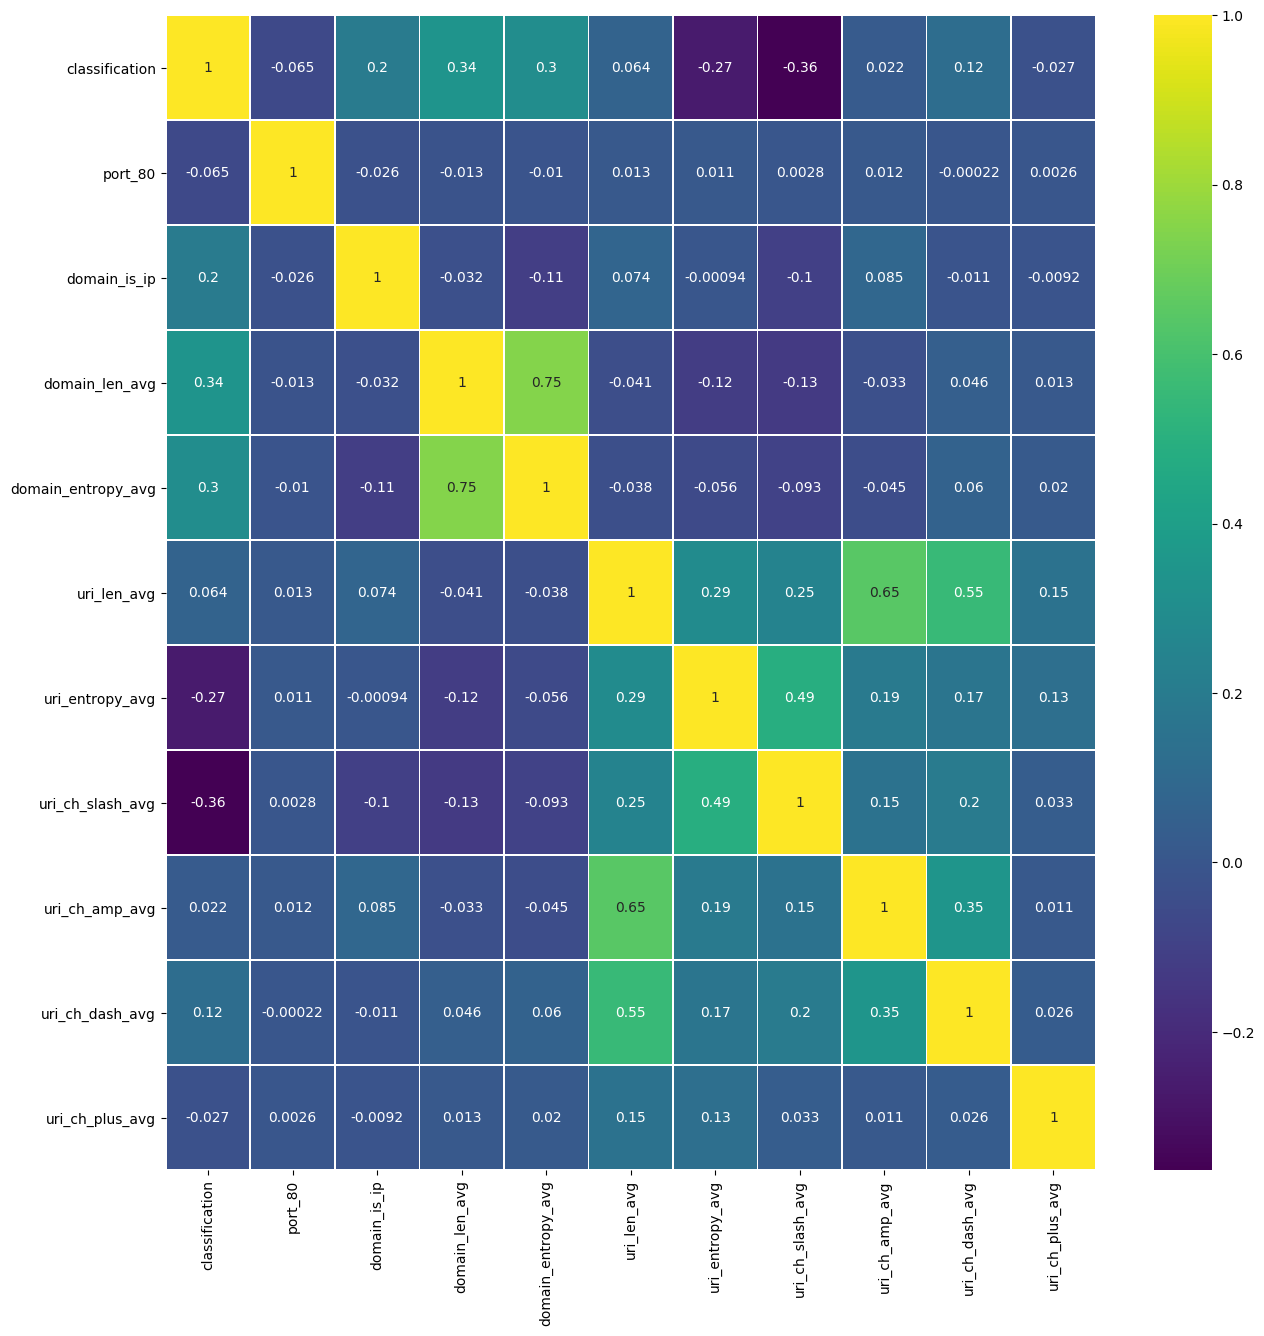

In [882]:
# Data analysis

# Only process mal/ben?
#df = df[df['classification'] == 1]
#df = df[df['redir_no'] != 0]

# Extract features we want
#df = df.filter(['classification','sample', 'redir_referrer', 'redir_location', 'redir_html', 'redir_js', 'redir_iframe','redir_subdomain', 'redir_concat', 'redir_base64', 'redir_unknown']) # Redirect
df = df.filter(['classification','sample','port_80', 'domain_is_ip','domain_len_avg','domain_entropy_avg','uri_len_avg','uri_entropy_avg','uri_ch_slash_avg', 'uri_ch_amp_avg','uri_ch_dash_avg','uri_ch_plus_avg']) # URL
#df = df.filter(['classification','sample','bytes_shockwave_avg', 'bytes_x-dosexec_avg', 'bytes_java_avg', 'bytes_silverlight_avg', 'bytes_javascript_avg', 'bytes_xml_avg', 'bytes_zip_avg', 'bytes_image_avg', 'bytes_html_avg']) # Content
#df = df.filter(['sample','redir_time', 'node_depth', 'response_len_avg', 'port_80', 'domain_is_ip']) # Extra
#df = df.drop(['tld','response_len_total','bytes_shockwave_total','bytes_x-dosexec_total','bytes_java_total', 'bytes_silverlight_total','bytes_javascript_total','bytes_xml_total','bytes_zip_total','bytes_image_total','bytes_html_total','uri_ch_slash_total', 'uri_ch_amp_avg','uri_ch_dash_avg','redir_no'], axis=1) # All

def first_last(a):
    return a.iloc[[-1]]

# Group samples by name
# tld = tld.groupby(['sample','tld'],sort=False)
#tld.value_counts().to_csv('node0_tld_benign_counts.csv')
# tld.describe().to_csv("tld_benign.csv")
df = df.groupby('sample',sort=False).mean()

#df.to_csv('node1-n_URI_malicious.csv')

corrmat = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corrmat,cmap='viridis',annot=True,linewidths=0.5)

# print(df.describe())
# df.describe().to_csv('describe_features.csv')

# df.hist(figsize=(15,15))
# pd.plotting.hist_frame(df, figsize=(15,15))
#pd.plotting.hist_frame(tld, figsize=(15,15))

# Assign colours to classifications
# color_wheel = {1: "#0392cf", 
#                2: "#ee4035"}
# colors = df['classification'].map(lambda x: color_wheel.get(x + 1))
# pd.plotting.scatter_matrix(df.drop(['classification'], axis=1), color=colors, alpha=0.6, figsize=(15, 15), diagonal='hist')

#pd.plotting.scatter_matrix(df, figsize=(15,15))
#plt.show()

In [ ]:
# Data analysis

# Only process mal/ben?
df = df[df['classification'] == 0]

# Extract features we want
#df = df.filter(['classification','sample', 'redir_referrer', 'redir_location', 'redir_html', 'redir_js', 'redir_iframe','redir_subdomain', 'redir_concat', 'redir_base64', 'redir_unknown']) # Redirect
#df = df.filter(['classification','sample','domain_len_avg', 'domain_entropy_avg', 'uri_len_avg', 'uri_entropy_avg', 'uri_ch_slash_avg', 'uri_ch_amp_avg', 'uri_ch_dash_avg', 'uri_ch_plus_avg']) # URL
#df = df.filter(['classification','sample','bytes_shockwave_avg', 'bytes_x-dosexec_avg', 'bytes_java_avg', 'bytes_silverlight_avg', 'bytes_javascript_avg', 'bytes_xml_avg', 'bytes_zip_avg', 'bytes_image_avg', 'bytes_html_avg']) # Content
tld = df.filter(['sample','tld'])
df = df.filter(['sample','redir_time', 'node_depth', 'response_len_avg', 'port_80', 'domain_is_ip']) # Extra
#df = df.drop(['tld','response_len_total','bytes_shockwave_total','bytes_x-dosexec_total','bytes_java_total', 'bytes_silverlight_total','bytes_javascript_total','bytes_xml_total','bytes_zip_total','bytes_image_total','bytes_html_total','uri_ch_slash_total', 'uri_ch_amp_avg','uri_ch_dash_avg','redir_no'], axis=1) # All

# Group samples by name
tld = tld.groupby('tld',sort=False)
tld.describe().to_csv("tld_malicious.csv")
#df = df.groupby('sample',sort=False).mean()

# print(df.loc[1])
# print(df.shape)

# print(df.describe())
# df.describe().to_csv('describe_features.csv')

# df.hist(figsize=(15,15))
# pd.plotting.hist_frame(df, figsize=(15,15))
#pd.plotting.hist_frame(tld, figsize=(15,15))

# Assign colours to classifications
# color_wheel = {1: "#0392cf", 
#                2: "#ee4035"}
# colors = df['classification'].map(lambda x: color_wheel.get(x + 1))
# pd.plotting.scatter_matrix(df.drop(['classification'], axis=1), color=colors, alpha=0.6, figsize=(15, 15), diagonal='hist')

#pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.show()

In [ ]:
# Data analysis
# Use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Get the figure
f = plt.figure()

# Extract features we want
# df = df.filter(['classification','sample', 'redir_referrer', 'redir_location', 'redir_html', 'redir_js', 'redir_iframe','redir_subdomain', 'redir_concat', 'redir_base64', 'redir_unknown']) # Redirect
df = df.filter(['classification','sample','domain_len_avg', 'domain_entropy_avg', 'uri_len_avg', 'uri_entropy_avg', 'uri_ch_slash_avg', 'uri_ch_amp_avg', 'uri_ch_dash_avg', 'uri_ch_plus_avg']) # URL
# df = df.filter(['classification','sample','bytes_shockwave_avg', 'bytes_x-dosexec_avg', 'bytes_java_avg', 'bytes_silverlight_avg', 'bytes_javascript_avg', 'bytes_xml_avg', 'bytes_zip_avg', 'bytes_image_avg', 'bytes_html_avg']) # Content
# df = df.filter(['classification','sample','redir_time', 'node_depth', 'response_len_avg', 'port_80', 'domain_is_ip']) # Extra
#df = df.drop(['tld','response_len_total','bytes_shockwave_total','bytes_x-dosexec_total','bytes_java_total', 'bytes_silverlight_total','bytes_javascript_total','bytes_xml_total','bytes_zip_total','bytes_image_total','bytes_html_total','uri_ch_slash_total', 'uri_ch_amp_avg','uri_ch_dash_avg','redir_no'], axis=1) # All

# Group samples by name
df = df.groupby('sample',sort=False).mean()

# Only process mal/ben?
mal_df = df[df['classification'] == 1]
ben_df = df[df['classification'] == 0]

# Density ensures uneven dataset (mal:ben) is accounted for
kwargs = dict(alpha=0.7, density=True, stacked=True, bins=10)
plt.hist(ben_df['uri_ch_plus_avg'], **kwargs, label='benign', color='blue')
plt.hist(mal_df['uri_ch_plus_avg'], **kwargs, label='malicious', color='red')
plt.title(r'URI ampersand count', fontsize=11)
plt.xlim(0,5)
plt.legend()

plt.show()